# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `multichannel=True`._


In [51]:
import skimage.util as util
import skimage.io as io
import skimage.color as color
import skimage.morphology as morph
import skimage.segmentation as seg
import numpy as np
import os as os
import matplotlib.pyplot as plt

% matplotlib inline

def segleaf(I):
    """
    Leaf segmentation using random walker
    :param I: Input image
    
    (Feel free to add as many addtional parameters as you
    want/need.)
    
    :return: 
    """
    BKGRD = 1
    FRGRD = 2
    I_label = np.zeros((I.shape[0], I.shape[1]), dtype=int)
    for row in range(I_label.shape[0]):
        for col in range(I_label.shape[1]):
            if all(I[row,col,] > 150) or all(I[row,col,] < 40):
                I_label[row, col] = BKGRD
            elif ((I[row, col, 0] + 0.0) > (I[row, col, 1] + 30.0)):
                I_label[row, col] = BKGRD
            elif ((I[row, col, 2] + 0.0) > (I[row, col, 0] + 30.0)):
                I_label[row, col] = BKGRD
            elif ((I[row, col, 1] + 0.0) > (I[row, col, 0] + 10.0)) and ((I[row, col, 1] + 0.0) > (I[row, col, 2] + 10.0)):
                I_label[row, col] = FRGRD
                
    #plt.imshow(I_label * 125, cmap = 'gray')
    I_thres = seg.random_walker(I, I_label, multichannel=True) > 1.5
    I_thres = morph.remove_small_holes(I_thres, min_size=8192) 
    I_thres = morph.remove_small_objects(I_thres, min_size=21750)
    return I_thres


# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image 
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, don't forget to print the average DSC for all images.  If you're getting a mean DSC of greater than 0.8, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [52]:
def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))


# Write your validation driver here.  It should be structured similarly to the driver in Assignment 3.
images_path = os.path.join('.', 'noisyimages')
gt_path = os.path.join('.', 'groundtruth')

dscl = []
count_regc = 0
count_img = 0
best_dsc = 0
worst_dsc = 1

# Iterate over all files in the original images folder
for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
            
        # concatenate variable root with filename to get the path to an input file.
        count_img= count_img + 1
        fname = os.path.join(root, filename)
        I = io.imread(fname)
        gtfilename = 'threshimage_' + filename[-8:]
        I_gt = io.imread(os.path.join('groundtruth', gtfilename))
        I_thres = segleaf(I)
        #io.imsave(os.path.join('segmented', filename), util.img_as_uint(I_thres))
        I_gt_bool = I_gt > 125
        dsc = dice_coefficient(I_thres, I_gt_bool)
        if dsc > 0.6:
            count_regc = count_regc + 1
        if dsc > best_dsc:
            best_dsc = dsc
            best_img = I
            best_img_gt = I_gt
            best_img_seg = I_thres
        if dsc < worst_dsc:
            worst_dsc = dsc
            worst_img = I
            worst_img_gt = I_gt
            worst_img_seg = I_thres
        print("DSC for %s: %.12f" % (filename, dsc))
        print("--------------------------------------------------")
        dscl.append(dsc)
        
print("The mean Dice coefficient was: %.12f" % np.mean(dscl))
print("The std. deviation of Dice coefficient was: %.12f" % np.std(dscl))
print("%.1f%% of leaves were recognized." % (count_regc * 100.0 / count_img))

/Users/wbb/anaconda3/envs/cmpt819/lib/python3.7/site-packages/skimage/morphology/misc.py:206: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  warn("the min_size argument is deprecated and will be removed in " +


DSC for image_0001.png: 0.985838433617
--------------------------------------------------
DSC for image_0002.png: 0.966519459012
--------------------------------------------------
DSC for image_0005.png: 0.981803168578
--------------------------------------------------
DSC for image_0007.png: 0.988479195469
--------------------------------------------------
DSC for image_0009.png: 0.988227375479
--------------------------------------------------
DSC for image_0010.png: 0.991197558465
--------------------------------------------------
DSC for image_0011.png: 0.981814095702
--------------------------------------------------
DSC for image_0015.png: 0.983120895309
--------------------------------------------------
DSC for image_0018.png: 0.976351720723
--------------------------------------------------
DSC for image_0019.png: 0.980290151083
--------------------------------------------------
DSC for image_0078.png: 0.993598893605
--------------------------------------------------
DSC for im

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the boundary of the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


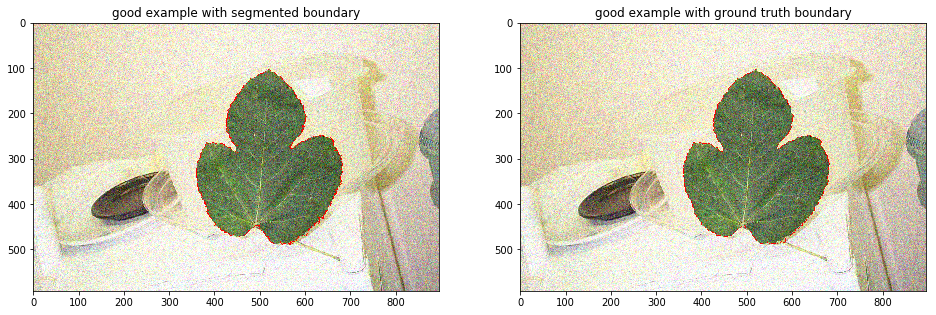

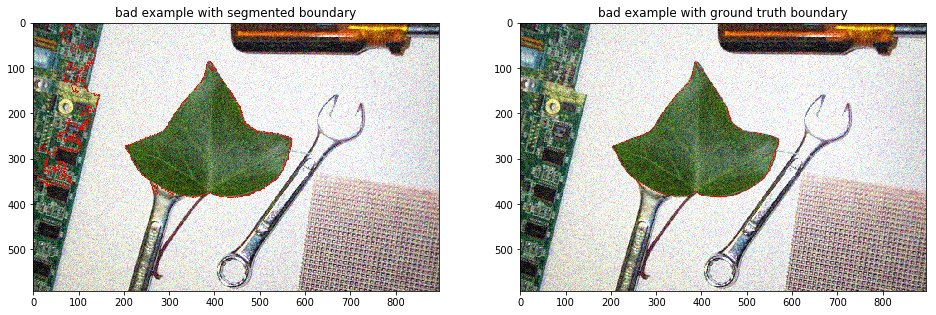

In [53]:
import matplotlib.pyplot as plt

% matplotlib inline
plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1)
plt.title("good example with segmented boundary")
L_best_img_seg = morph.label(best_img_seg, connectivity=2)
best_image_with_boundaries_seg = seg.mark_boundaries(best_img, L_best_img_seg, color=(1,0,0))
plt.imshow(best_image_with_boundaries_seg)
plt.subplot(1,2,2)
plt.title("good example with ground truth boundary")
binary_best_img_gt = best_img_gt > 125
L_best_img_gt = morph.label(binary_best_img_gt, connectivity=2)
best_image_with_boundaries_gt = seg.mark_boundaries(best_img, L_best_img_gt, color=(1,0,0))
plt.imshow(best_image_with_boundaries_gt)

plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1)
plt.title("bad example with segmented boundary")
L_worst_img_seg = morph.label(worst_img_seg, connectivity=2)
worst_image_with_boundaries_seg = seg.mark_boundaries(worst_img, L_worst_img_seg, color=(1,0,0))
plt.imshow(worst_image_with_boundaries_seg)
plt.subplot(1,2,2)
plt.title("bad example with ground truth boundary")
binary_worst_img_gt = worst_img_gt > 125
L_worst_img_gt = morph.label(binary_worst_img_gt, connectivity=2)
worst_image_with_boundaries_gt = seg.mark_boundaries(worst_img, L_worst_img_gt, color=(1,0,0))
plt.imshow(worst_image_with_boundaries_gt)

# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  In label array, I assume that unlabeled pixels have value 0, background pixels have value 1, and foreground pixels have value 2. 
    
    I label green pixels as foreground pixels. In my algorithm, green pixels are those pixels whose values of green channel are larger 10 than other two channels.
    
    Also I label too white pixels (values of all three channels are very large), too dark pixels (values of all three channels are very small), and not green pixels (value of red channel or blue channel is larger than green channel's a lot) as background pixels.
    
    Leaving rest pixels as unlabeled pixels.
    
    Applying random walker algorithm to the origin image and the corresponding label array, we get a labeled image. After removing small structures and thresholding, we can get the bool image we want. 

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_ My algorithm cannot exclude objects that have very samilar color pattern with leaves. In the bad example, the circuit board also has green color. Also, the size of it are quite large, so it cannot be removed by basic region processing.
